# Baseline for Hot Topics in Computer Vision - Seminar 2
## Addressing Label Scarcity in the Semantic Analysis of Earth Observation Imagery  

This is the Baseline classifier. We trained it on the xview2 dataset for the four predefined sizes 10%, 25%, 50% and 100%.

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import datetime
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image


## Execute for Collab

In [ ]:
#google colab
from google.colab import drive
drive.mount('/content/drive')

## Constants

In [2]:
# Mappings for utility
MAP_PERCENT_TO_AMOUNT = {
    "10" : 280,
    "25" : 700,
    "50" : 1400,
    "100": 2799
}

DAMAGE_LEVEL_TO_SCORE = {
    "destroyed" : 4,
    "major-damage" : 3,
    "minor-damage" : 2,
    "no-damage" : 1,
    "no-building" : 0
}

SCORE_TO_DAMAGE_LEVEL = {
    0 : "no-building",
    1 : "no-damage",
    2 : "minor-damage",
    3 : "major-damage",
    4 : "destroyed",
}

NUM_CLASSES = 5  # Number of output classes

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configs

Define the network if wanted.
*PERCENT* can be assigned to the four different sizes, "10", "25", etc.

In [5]:
PERCENT = "10"
TRAIN_SET_SIZE = MAP_PERCENT_TO_AMOUNT[PERCENT]

PRETRAINED = False
BATCH_SIZE = 128
NUM_EPOCHS=5
LEARNING_RATE=0.001
MOMENTUM=0.9
ARCHITECTURE = "rn18"
MODEL_OPTIMIZER = "SGD"

## File Paths

- DATASET_DIR: path to the ordered dataset directory
- XVIEW2_TXT_FILE: path to xview2 txt fil
- MODEL_OUTPUT_DIR: path to directory where model values will be saved

In [9]:
DATASET_DIR = "../dataset/"
XVIEW2_TXT_FILE = "../data/xview2.txt"
MODEL_OUTPUT_DIR = "../models/"

## Baseline Classifier

In [7]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()

        self.resnet = models.resnet18(pretrained=PRETRAINED)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

## Load Dataloader

In [10]:
TRAINING_SET_ENTRIES = open(XVIEW2_TXT_FILE,'r').read().splitlines()[:TRAIN_SET_SIZE]

# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = torchvision.datasets.ImageFolder(
    os.path.join(DATASET_DIR,"train"), transform=transform
)
subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in TRAINING_SET_ENTRIES]
dataloader = torch.utils.data.DataLoader(
    subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2
)

# Train model

In [11]:
TRAIN_MODEL = True
if TRAIN_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE, MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    epoch_loss_list = []
    epoch_accuracy_list = []
    for epoch in range(NUM_EPOCHS):
        step_loss = []
        total = 0.0
        correct = 0.0
        for images, labels in dataloader:
            images, labels =  images.to(DEVICE),labels.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            optimizer.step()

            step_loss.append(loss.item())
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = np.array(step_loss).mean()
        epoch_loss_list.append(epoch_loss)
        epoch_accuracy = 100.*correct/total
        epoch_accuracy_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}")


/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Loss: 1.820, Accuracy: 20.714
Epoch 2/5, Loss: 1.480, Accuracy: 28.571
Epoch 3/5, Loss: 1.454, Accuracy: 41.071
Epoch 4/5, Loss: 1.572, Accuracy: 41.071
Epoch 5/5, Loss: 1.343, Accuracy: 41.071


## Save Model

Save model weights in MODEL_OUTPUT_DIR

In [12]:

SAVE_MODEL = True
if SAVE_MODEL:
    out_dir = os.path.join(MODEL_OUTPUT_DIR,ARCHITECTURE +'_size_' + str(TRAIN_SET_SIZE) + '_pretrained_'+ str(PRETRAINED) + "_batch_"+str(BATCH_SIZE)+"_epochs_"+str(NUM_EPOCHS)
                           +"_optim_" +MODEL_OPTIMIZER + "_lr_"+str(LEARNING_RATE) + "_mom_"+str(MOMENTUM))
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    TIME_NOW_STR = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    SAVE_MODEL_FILE = os.path.join(out_dir,TIME_NOW_STR)
    torch.save(model.state_dict(), SAVE_MODEL_FILE + '.pth')


## Plot Training Loss and Accuracy

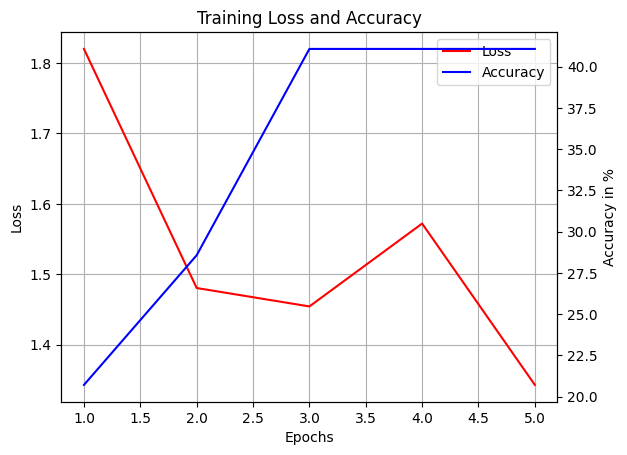

<Figure size 640x480 with 0 Axes>

In [13]:
if TRAIN_MODEL:
    # Plot Loss
    fig, ax1 = plt.subplots()
    ax1.plot(range(1,NUM_EPOCHS+1), epoch_loss_list, 'r-', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss and Accuracy')
    ax1.grid(True)

    # Plot Accuracy
    ax2 = ax1.twinx()
    ax2.plot(range(1,NUM_EPOCHS+1), epoch_accuracy_list, 'b-', label='Accuracy')
    ax2.set_ylabel('Accuracy in %')

    # Add Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels)

    plt.show()

    plt.savefig(os.path.join(out_dir, 'train_loss_accuracy.svg'), format='svg')

## Test Model

Evaluate model performance on test dataset.  
Set *LOAD_MODEL* to True and define *LOAD_MODEL_FILE* to evaluate an existing model that fits the defined architecture.

In [19]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2, pin_memory=True)

In [15]:
LOAD_MODEL = False
LOAD_MODEL_FILE = MODEL_OUTPUT_DIR + "size_280_pretrained_False_batch_32_epochs_15_optim_SGD_lr_0.01_mom_0.9/"+ "06-23-2023_18-20-16.pth"
if LOAD_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.load_state_dict(torch.load(LOAD_MODEL_FILE))

In [16]:
model.eval()
model.to(DEVICE)

y_pred, y_truth = [], []

with torch.no_grad():
    for idx,(images, labels) in enumerate(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # save predictions and ground truth
        y_truth.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# calculate accuracy
accuracy = correct / total
y_truth = torch.tensor(y_truth)
y_pred = torch.tensor(y_pred)

## Plot Confusion Matrix
Calculate Overall and Average Accuracy

Overall Accuracy: 0.421
Average Accuracy: 0.241


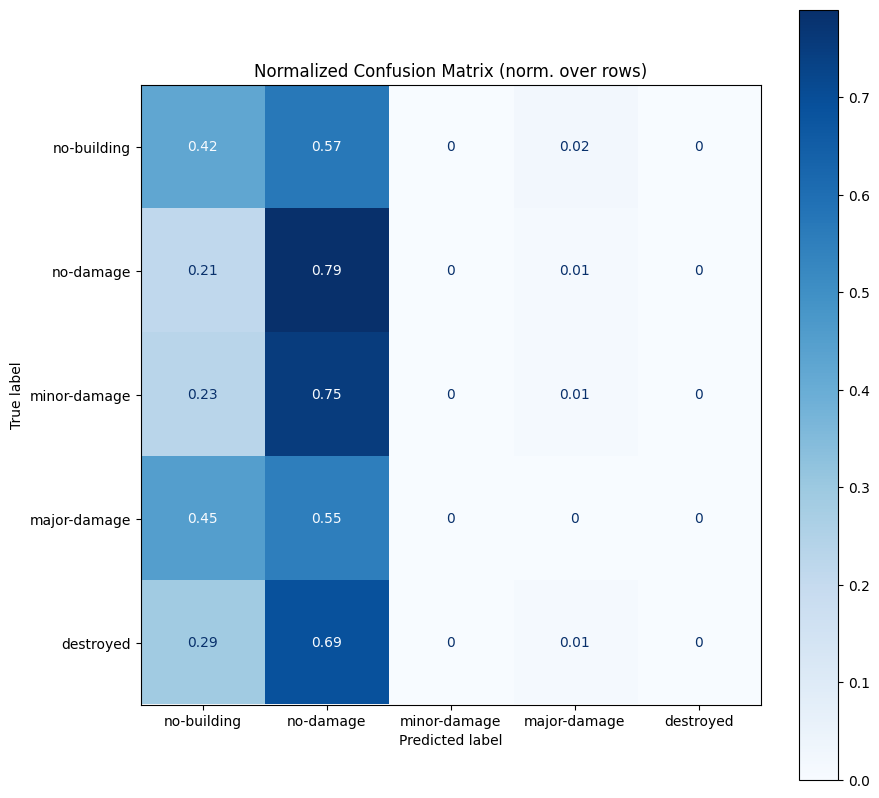

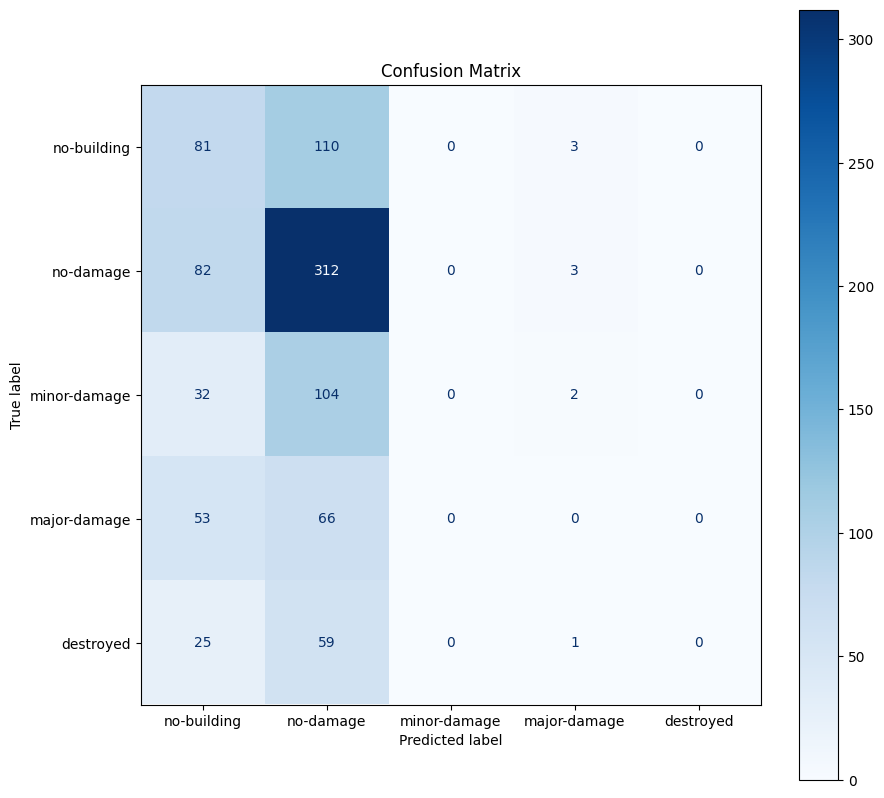

In [20]:

cm_norm = confusion_matrix(y_truth, y_pred, normalize="true")
cm = confusion_matrix(y_truth, y_pred)
l = [SCORE_TO_DAMAGE_LEVEL[i] for i in range(NUM_CLASSES)]

# Print Overall and Average Accuracy
overall_accuracy = np.sum(np.diag(cm))/np.sum(cm)
print(f'Overall Accuracy: {overall_accuracy:.3f}')
average_accuracy =  np.mean(np.diag(cm) / np.sum(cm, axis=1))
print(f'Average Accuracy: {average_accuracy:.3f}')

file_path = os.path.join(out_dir,"accuracy.csv")
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([f"Overall_Accuracy={overall_accuracy:.3f}"])
    writer.writerow([f"Average_Accuracy={average_accuracy:.3f}"])

# Display Normalized Confusion Matrix
disp = ConfusionMatrixDisplay(np.around(cm_norm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalized Confusion Matrix (norm. over rows)")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm_norm.svg'), format='svg')

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(np.around(cm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Confusion Matrix")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm.svg'), format='svg')

## Save Confusion Mat

Save model if wanted to the model directory

In [18]:
SAVE_CM = True
if SAVE_CM:
    if(SAVE_MODEL):
        CM_FILE = SAVE_MODEL_FILE
    elif(LOAD_MODEL):
        CM_FILE = LOAD_MODEL_FILE
    with open(os.path.join(out_dir,'saved_cm.json'), 'w') as json_file:
        json.dump(cm.tolist(), json_file)